## Performance

## Functions of performance testing

In [ ]:
import time
import tracemalloc
import statistics
from contextlib import contextmanager
from typing import Dict, Callable
from tqdm import tqdm
import matplotlib.pyplot as plt
from RSA.RSA_1 import RSA as RSA_1
from RSA.RSA_2 import RSA as RSA_2
from RSA.RSA_3 import RSA as RSA_3
from RSA.RSA_4 import RSA as RSA_4
from ElGamal.ElGamal_5 import ElGamal

@contextmanager
def trace_memory():
    """改进的内存跟踪上下文管理器"""
    tracemalloc.start()
    snapshot = tracemalloc.take_snapshot()
    mem_diff = [0]  # 使用列表存储内存差值以便修改
    try:
        yield mem_diff
    finally:
        new_snapshot = tracemalloc.take_snapshot()
        stats = new_snapshot.compare_to(snapshot, 'lineno')
        total = sum(stat.size_diff for stat in stats if stat.size_diff > 0)
        mem_diff[0] = total
        tracemalloc.stop()

def measure_performance(encrypt_func: Callable, decrypt_func: Callable, data: str, config) -> Dict:
    """增强的性能测量函数"""
    # 确保初始加密成功
    try:
        cipher = encrypt_func()
    except Exception as e:
        raise RuntimeError(f"初始加密失败: {str(e)}")

    # 预热阶段（增加异常处理）
    for _ in range(config.WARMUP_ROUNDS):
        try:
            encrypt_func()
            decrypt_func()
        except Exception as e:
            raise RuntimeError(f"预热阶段失败: {str(e)}")

    # 改进的内存测量（多次采样取最大）
    encrypt_mem_samples = []
    decrypt_mem_samples = []
    
    for _ in range(config.MEMORY_SAMPLES):
        with trace_memory() as mem_diff:
            encrypt_func()
        encrypt_mem_samples.append(mem_diff[0])
        
        with trace_memory() as mem_diff:
            decrypt_func()
        decrypt_mem_samples.append(mem_diff[0])

    # 时间测量（增加异常处理和抗差处理）
    def time_it(func: Callable, rounds: int) -> list:
        times = []
        for _ in tqdm(range(rounds), desc=f"Processing {func.__name__}"):
            try:
                start = time.perf_counter()
                func()
                times.append(time.perf_counter() - start)
            except Exception as e:
                raise RuntimeError(f"计时测试失败: {str(e)}")
        # 去除10%的异常值
        cutoff = int(len(times) * 0.1)
        if cutoff > 0:
            times = sorted(times)[cutoff:-cutoff]
        return times

    encrypt_times = time_it(lambda: encrypt_func(), config.TEST_ROUNDS)
    decrypt_times = time_it(lambda: decrypt_func(), config.TEST_ROUNDS)

    return {
        "encrypt_times": encrypt_times,
        "decrypt_times": decrypt_times,
        "encrypt_mem": max(encrypt_mem_samples),
        "decrypt_mem": max(decrypt_mem_samples)
    }

def format_results(data_size: int, results: Dict) -> Dict:
    """Improved results formatting (including statistical metrics)"""
    size_mb = data_size / 1e6
    encrypt_avg = statistics.mean(results['encrypt_times'])
    decrypt_avg = statistics.mean(results['decrypt_times'])
    
    return {
        "Fastest Encryption Time (s)": f"{min(results['encrypt_times']):.6f}",
        "Slowest Encryption Time (s)": f"{max(results['encrypt_times']):.6f}",
        "Median Encryption Time (s)": f"{statistics.median(results['encrypt_times']):.6f}",
        "Fastest Decryption Time (s)": f"{min(results['decrypt_times']):.6f}",
        "Slowest Decryption Time (s)": f"{max(results['decrypt_times']):.6f}",
        "Median Decryption Time (s)": f"{statistics.median(results['decrypt_times']):.6f}",
        "Encryption Throughput (MB/s)": f"{size_mb / encrypt_avg:.6f}",
        "Decryption Throughput (MB/s)": f"{size_mb / decrypt_avg:.6f}",
        "Encryption Peak Memory (MB)": f"{results['encrypt_mem'] / 1e6:.6f}",
        "Decryption Peak Memory (MB)": f"{results['decrypt_mem'] / 1e6:.6f}",
    }

def test_algorithm(alg_class, key_length: int, data: str, config) -> Dict:
    try:
        instance = alg_class(bit_length=key_length)
        public, private = instance.generate_keys()
    except Exception as e:
        raise RuntimeError(f"算法初始化失败: {str(e)}")
    
    # 封装加密解密函数（增加类型检查）
    def encrypt_wrapper(text: str):
        if isinstance(instance, RSA_1) or isinstance(instance, RSA_2) or isinstance(instance, RSA_3) or isinstance(instance, RSA_4):
            return instance.encrypt_text(text, public)
        elif isinstance(instance, ElGamal):
            return instance.encrypt(text)
        else:
            raise ValueError("不支持的算法类型")

    def decrypt_wrapper(cipher):
        if isinstance(instance, RSA_1) or isinstance(instance, RSA_2) or isinstance(instance, RSA_3) or isinstance(instance, RSA_4):
            return instance.decrypt_text(cipher)
        elif isinstance(instance, ElGamal):
            return instance.decrypt(cipher)
        else:
            raise ValueError("不支持的算法类型")

    # 确保使用相同的密文进行解密测试
    cipher = encrypt_wrapper(data)
    
    return measure_performance(
        encrypt_func=lambda: encrypt_wrapper(data),
        decrypt_func=lambda: decrypt_wrapper(cipher),
        data=data,
        config=config
    )

def print_comparison(results: Dict):
    """Enhanced results display (including more statistical metrics)"""
    metrics = [
        ("Median Encryption Time (s)", "Median Encryption Time"),
        ("Median Decryption Time (s)", "Median Decryption Time"),
        ("Encryption Throughput (MB/s)", "Encryption Throughput"),
        ("Decryption Throughput (MB/s)", "Decryption Throughput"),
        ("Encryption Peak Memory (MB)", "Encryption Memory"),
        ("Decryption Peak Memory (MB)", "Decryption Memory"),
    ]

    print("\n## Performance Comparison Report of Encryption Algorithms")
    print("| Metric | " + " | ".join(results.keys()) + " |")
    print("|--------|" + "|".join(["---"] * len(results)) + "|")
    
    for metric, name in metrics:
        row = [name] + [v[metric] for v in results.values()]
        print(f"| {' | '.join(row)} |")


## Visualization

In [17]:
import matplotlib.pyplot as plt
import numpy as np

def plot_results(comparison: dict):
    """Enhanced visualization with side-by-side comparison"""
    # 数据准备
    labels = list(comparison.keys())
    bar_width = 0.35
    
    # 提取指标数据
    time_metrics = {
        'encrypt': [float(comparison[label]["Median Encryption Time (s)"]) for label in labels],
        'decrypt': [float(comparison[label]["Median Decryption Time (s)"]) for label in labels]
    }
    
    throughput_metrics = {
        'encrypt': [float(comparison[label]["Encryption Throughput (MB/s)"]) for label in labels],
        'decrypt': [float(comparison[label]["Decryption Throughput (MB/s)"]) for label in labels]
    }

    # 创建画布
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    x = np.arange(len(labels))  # x轴位置
    
    # 时间对比子图
    time_bars1 = ax1.bar(x - bar_width/2, time_metrics['encrypt'], bar_width,
                        color='#1f77b4', label='Encrypt Time (s)')
    time_bars2 = ax1.bar(x + bar_width/2, time_metrics['decrypt'], bar_width,
                        color='#ff7f0e', label='Decrypt Time (s)')
    
    # 吞吐量对比子图
    throughput_bars1 = ax2.bar(x - bar_width/2, throughput_metrics['encrypt'], bar_width,
                              color='#2ca02c', label='Encrypt Throughput (MB/s)')
    throughput_bars2 = ax2.bar(x + bar_width/2, throughput_metrics['decrypt'], bar_width,
                              color='#d62728', label='Decrypt Throughput (MB/s)')

    # 配置时间子图
    ax1.set_title('Median Time Comparison', fontsize=14, pad=20)
    ax1.set_ylabel('Algorithms', fontsize=12)
    ax1.set_xlabel('Time (seconds)', fontsize=12)
    ax1.set_xticks(x)
    ax1.set_xticklabels(labels, rotation=45, ha='right')
    ax1.grid(axis='y', linestyle='--', alpha=0.7)
    
    # 配置吞吐量子图
    ax2.set_title('Throughput Comparison', fontsize=14, pad=20)
    ax2.set_xlabel('Throughput (MB/s)', fontsize=12)
    ax2.set_xticks(x)
    ax2.set_xticklabels(labels, rotation=45, ha='right')
    ax2.grid(axis='y', linestyle='--', alpha=0.7)

    # 添加数据标签
    def add_labels(ax, bars):
        for bar in bars:
            height = bar.get_height()
            ax.annotate(f'{height:.2f}',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),  # 3点垂直偏移
                        textcoords="offset points",
                        ha='center', va='bottom',
                        fontsize=9)

    add_labels(ax1, time_bars1)
    add_labels(ax1, time_bars2)
    add_labels(ax2, throughput_bars1)
    add_labels(ax2, throughput_bars2)

    # 统一图例
    handles, labels = ax1.get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', 
              bbox_to_anchor=(0.5, 1.1), ncol=2, fontsize=12)

    # 调整布局
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # 为图例留出空间
    plt.subplots_adjust(wspace=0.3)  # 调整子图间距
    
    # 显示图表
    plt.show()

## Configuration definition

In [ ]:
# Test configuration of 2048
class TestConfig_2048:
    TEST_TEXT = "A" * 200    # 测试文本
    RSA_KEY_LENGTH = 2048    # RSA推荐密钥长度
    ELGAMAL_KEY_LENGTH = 2048  # ElGamal等效安全长度
    WARMUP_ROUNDS = 10       # 预热轮数（增加预热次数）
    TEST_ROUNDS = 1          # 测试轮数
    MEMORY_SAMPLES = 5       # 内存测量采样次数

# Test configuration of 2048
class TestConfig_2048_100:
    TEST_TEXT = "A" * 200    # 测试文本
    RSA_KEY_LENGTH = 2048    # RSA推荐密钥长度
    ELGAMAL_KEY_LENGTH = 2048  # ElGamal等效安全长度
    WARMUP_ROUNDS = 10       # 预热轮数（增加预热次数）
    TEST_ROUNDS = 100        # 正式测试轮数
    MEMORY_SAMPLES = 5       # 内存测量采样次数

# # Test configuration of 1024
# class TestConfig_1024:
#     TEST_TEXT = "A" * 200   # 测试文本
#     RSA_KEY_LENGTH = 1024    # RSA推荐密钥长度
#     ELGAMAL_KEY_LENGTH = 1024  # ElGamal等效安全长度
#     WARMUP_ROUNDS = 10       # 预热轮数（增加预热次数）
#     TEST_ROUNDS = 100        # 正式测试轮数
#     MEMORY_SAMPLES = 5       # 内存测量采样次数

# class TestConfig_1024_100:
#     TEST_TEXT = "A" * 200   # 测试文本
#     RSA_KEY_LENGTH = 1024    # RSA推荐密钥长度
#     ELGAMAL_KEY_LENGTH = 1024  # ElGamal等效安全长度
#     WARMUP_ROUNDS = 10       # 预热轮数（增加预热次数）
#     TEST_ROUNDS = 100        # 正式测试轮数
#     MEMORY_SAMPLES = 5       # 内存测量采样次数

## 2048-key-length Pre-test (TEST-ROUNDS=1) 


## Performance Comparison Report of Encryption Algorithms
| Metric | RSA-1 | RSA-2 | RSA-3 | ElGamal-2048 |
|--------|---|---|---|---|
| Median Encryption Time | 0.001037 | 0.001399 | 0.000761 | 0.032094 |
| Median Decryption Time | 0.282915 | 0.361371 | 0.296914 | 0.017502 |
| Encryption Throughput | 0.192771 | 0.142990 | 0.262674 | 0.006232 |
| Decryption Throughput | 0.000707 | 0.000553 | 0.000674 | 0.011427 |
| Encryption Memory | 0.000176 | 0.000176 | 0.000176 | 0.000176 |
| Decryption Memory | 0.000176 | 0.000176 | 0.000176 | 0.000176 |


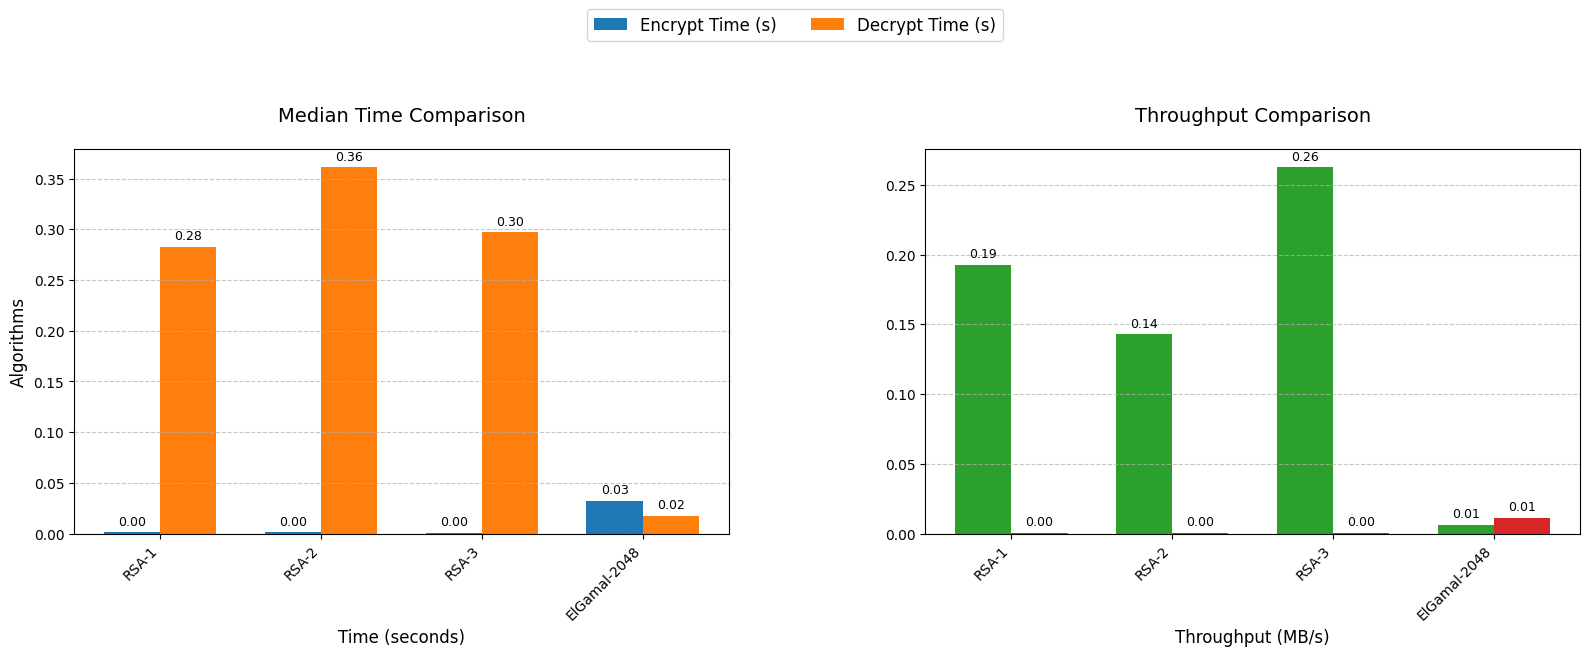


Test Description:
- Time measurement uses Python perf_counter() for high precision timing
- Memory measurement uses tracemalloc to track peak memory
- Test data: 200 bytes (0.2 KB)
- Test configuration: 10 warm-up rounds, 1 official test rounds
- Time results exclude 10% outliers, reporting median time


In [ ]:
if __name__ == "__main__":
    try:
        # 可以根据需要选择不同的配置类
        config = TestConfig_2048  # 选择2048位配置
        # config = TestConfig_1024  # 或者选择1024位配置

        # # 运行四个RSA算法测试
        rsa_results_1 = test_algorithm(RSA_1, config.RSA_KEY_LENGTH, config.TEST_TEXT, config)
        rsa_results_2 = test_algorithm(RSA_2, config.RSA_KEY_LENGTH, config.TEST_TEXT, config)
        rsa_results_3 = test_algorithm(RSA_3, config.RSA_KEY_LENGTH, config.TEST_TEXT, config)
        # # rsa_results_4 = test_algorithm(RSA_4, config.RSA_KEY_LENGTH, config.TEST_TEXT, config)

        # # ElGamal Test
        elgamal_results = test_algorithm(ElGamal, config.ELGAMAL_KEY_LENGTH, config.TEST_TEXT, config)

        comparison = {
            "RSA-1": format_results(len(config.TEST_TEXT), rsa_results_1),
            "RSA-2": format_results(len(config.TEST_TEXT), rsa_results_2),
            "RSA-3": format_results(len(config.TEST_TEXT), rsa_results_3),
            # "RSA-4": format_results(len(config.TEST_TEXT), rsa_results_4),
            "ElGamal-2048": format_results(len(config.TEST_TEXT), elgamal_results)
        }
        
        print_comparison(comparison)
        plot_results(comparison)

        print("\nTest Description:")
        print("- Time measurement uses Python perf_counter() for high precision timing")
        print("- Memory measurement uses tracemalloc to track peak memory")
        print(f"- Test data: {len(config.TEST_TEXT)} bytes ({len(config.TEST_TEXT)/1024:.1f} KB)")
        print(f"- Test configuration: {config.WARMUP_ROUNDS} warm-up rounds, {config.TEST_ROUNDS} official test rounds")
        print("- Time results exclude 10% outliers, reporting median time")
        
    except Exception as e:
        print(f"\nTest failed: {str(e)}")
        raise

## 2048-key-length Test (TEST-ROUNDS=100) 

Processing <lambda>: 100%|██████████| 100/100 [00:01<00:00, 55.79it/s]



## Performance Comparison Report of Encryption Algorithms
| Metric | RSA-1 | RSA-2 | RSA-3 | ElGamal-2048 |
|--------|---|---|---|---|
| Median Encryption Time | 0.000370 | 0.000506 | 0.000354 | 0.031510 |
| Median Decryption Time | 0.123008 | 0.125737 | 0.119473 | 0.017505 |
| Encryption Throughput | 0.529232 | 0.382996 | 0.553147 | 0.006326 |
| Decryption Throughput | 0.001626 | 0.001574 | 0.001648 | 0.011387 |
| Encryption Memory | 0.000176 | 0.000176 | 0.000176 | 0.000176 |
| Decryption Memory | 0.000176 | 0.000176 | 0.000176 | 0.000176 |


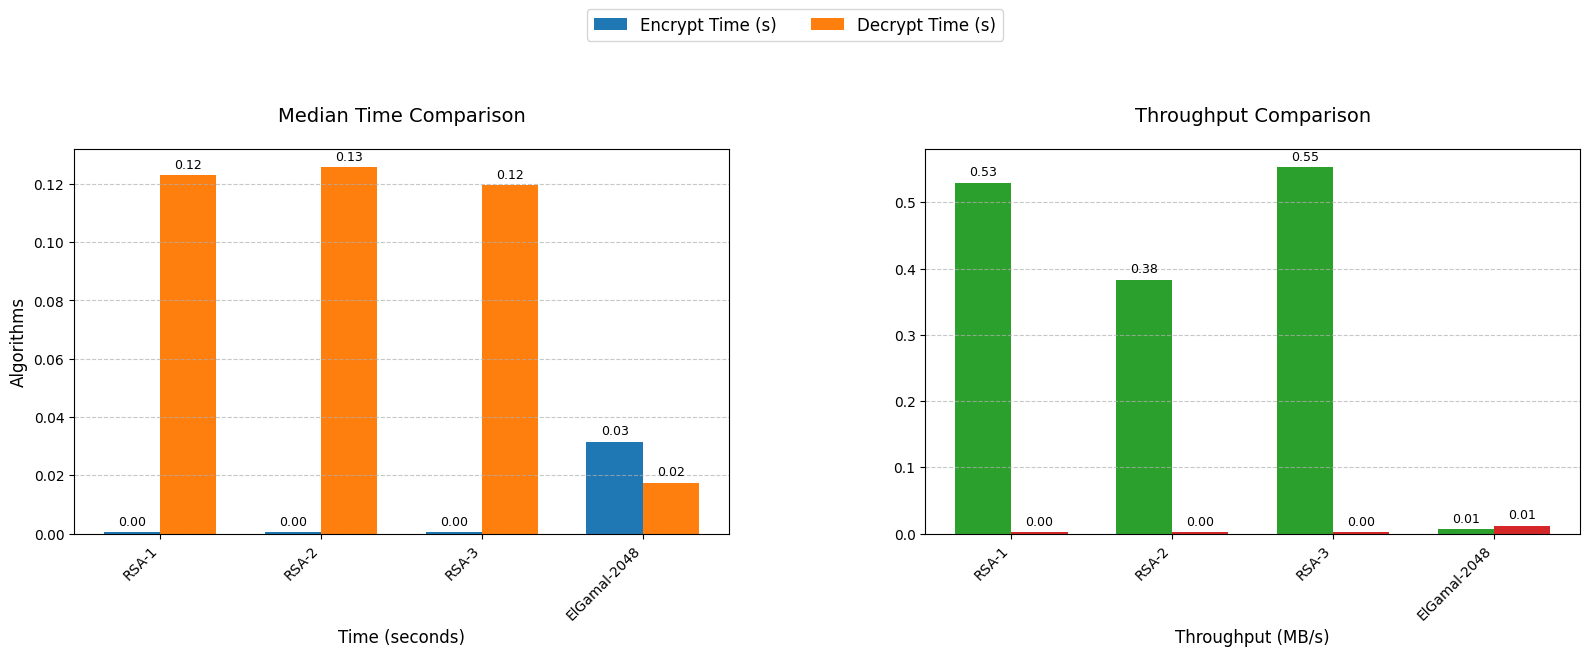


Test Description:
- Time measurement uses Python perf_counter() for high precision timing
- Memory measurement uses tracemalloc to track peak memory
- Test data: 200 bytes (0.2 KB)
- Test configuration: 10 warm-up rounds, 100 official test rounds
- Time results exclude 10% outliers, reporting median time


In [26]:
if __name__ == "__main__":
    try:
        # 可以根据需要选择不同的配置类
        config = TestConfig_2048_100  # 选择2048位配置
        # config = TestConfig_1024  # 或者选择1024位配置

        # # 运行四个RSA算法测试
        rsa_results_1_100 = test_algorithm(RSA_1, config.RSA_KEY_LENGTH, config.TEST_TEXT, config)
        rsa_results_2_100 = test_algorithm(RSA_2, config.RSA_KEY_LENGTH, config.TEST_TEXT, config)
        rsa_results_3_100 = test_algorithm(RSA_3, config.RSA_KEY_LENGTH, config.TEST_TEXT, config)
        # # rsa_results_4 = test_algorithm(RSA_4, config.RSA_KEY_LENGTH, config.TEST_TEXT, config)

        # # ElGamal Test
        elgamal_results_100 = test_algorithm(ElGamal, config.ELGAMAL_KEY_LENGTH, config.TEST_TEXT, config)

        comparison = {
            "RSA-1": format_results(len(config.TEST_TEXT), rsa_results_1_100),
            "RSA-2": format_results(len(config.TEST_TEXT), rsa_results_2_100),
            "RSA-3": format_results(len(config.TEST_TEXT), rsa_results_3_100),
            # "RSA-4": format_results(len(config.TEST_TEXT), rsa_results_4),
            "ElGamal-2048": format_results(len(config.TEST_TEXT), elgamal_results_100)
        }
        
        print_comparison(comparison)
        plot_results(comparison)

        print("\nTest Description:")
        print("- Time measurement uses Python perf_counter() for high precision timing")
        print("- Memory measurement uses tracemalloc to track peak memory")
        print(f"- Test data: {len(config.TEST_TEXT)} bytes ({len(config.TEST_TEXT)/1024:.1f} KB)")
        print(f"- Test configuration: {config.WARMUP_ROUNDS} warm-up rounds, {config.TEST_ROUNDS} official test rounds")
        print("- Time results exclude 10% outliers, reporting median time")
        
    except Exception as e:
        print(f"\nTest failed: {str(e)}")
        raise

## 2048-key-length Test (TEST-ROUNDS=100) Again

Processing <lambda>: 100%|██████████| 100/100 [00:01<00:00, 57.00it/s]



## Performance Comparison Report of Encryption Algorithms
| Metric | RSA-1 | RSA-2 | RSA-3 | ElGamal |
|--------|---|---|---|---|
| Median Encryption Time | 0.000361 | 0.000495 | 0.000364 | 0.030520 |
| Median Decryption Time | 0.121193 | 0.121924 | 0.120544 | 0.017082 |
| Encryption Throughput | 0.520672 | 0.400589 | 0.535062 | 0.006543 |
| Decryption Throughput | 0.001648 | 0.001640 | 0.001657 | 0.011695 |
| Encryption Memory | 0.000176 | 0.000176 | 0.000176 | 0.000176 |
| Decryption Memory | 0.000176 | 0.000360 | 0.000176 | 0.000176 |


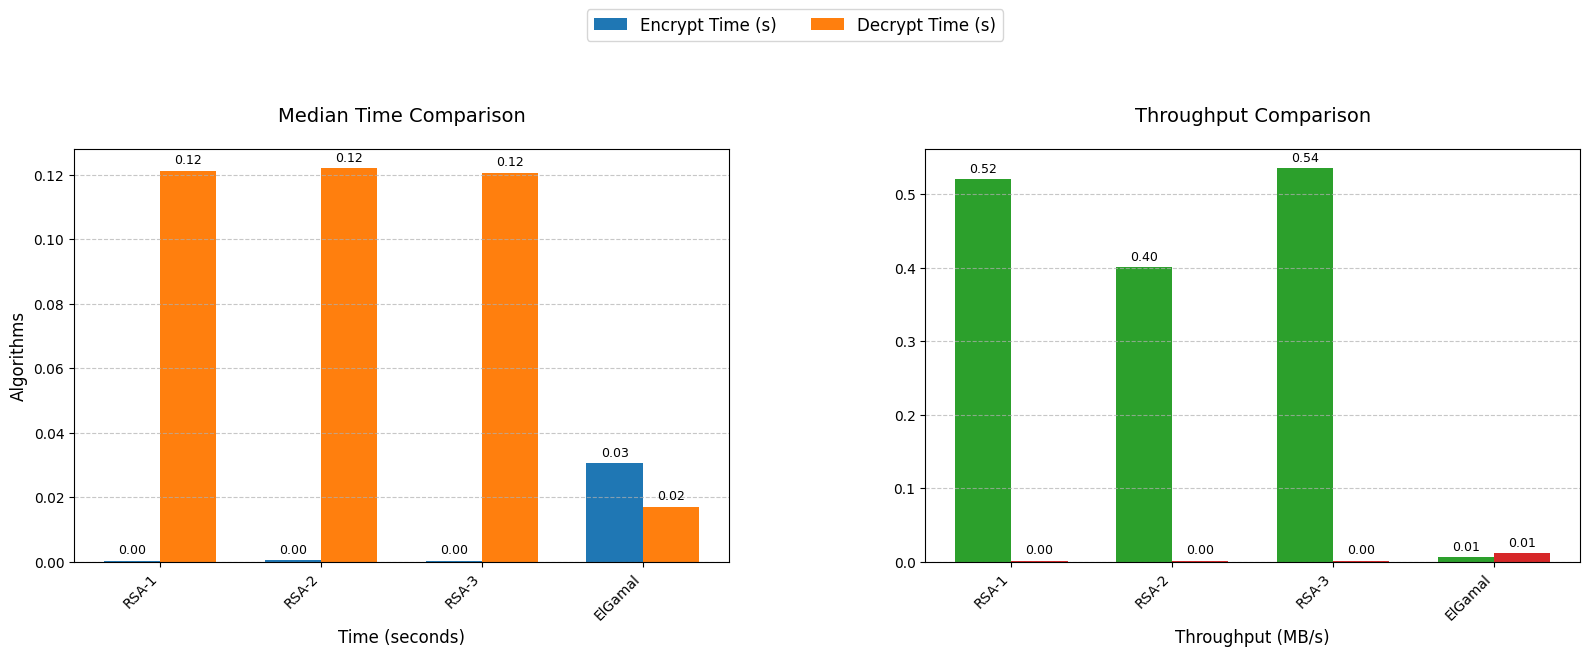


Test Description:
- Time measurement uses Python perf_counter() for high precision timing
- Memory measurement uses tracemalloc to track peak memory
- Test data: 200 bytes (0.2 KB)
- Test configuration: 10 warm-up rounds, 100 official test rounds
- Time results exclude 10% outliers, reporting median time


In [27]:
if __name__ == "__main__":
    try:
        # 可以根据需要选择不同的配置类
        config = TestConfig_2048_100  # 选择2048位配置
        # config = TestConfig_1024  # 或者选择1024位配置

        # # 运行四个RSA算法测试
        rsa_results_1_100 = test_algorithm(RSA_1, config.RSA_KEY_LENGTH, config.TEST_TEXT, config)
        rsa_results_2_100 = test_algorithm(RSA_2, config.RSA_KEY_LENGTH, config.TEST_TEXT, config)
        rsa_results_3_100 = test_algorithm(RSA_3, config.RSA_KEY_LENGTH, config.TEST_TEXT, config)
        # # rsa_results_4 = test_algorithm(RSA_4, config.RSA_KEY_LENGTH, config.TEST_TEXT, config)

        # # ElGamal Test
        elgamal_results_100 = test_algorithm(ElGamal, config.ELGAMAL_KEY_LENGTH, config.TEST_TEXT, config)

        comparison = {
            "RSA-1": format_results(len(config.TEST_TEXT), rsa_results_1_100),
            "RSA-2": format_results(len(config.TEST_TEXT), rsa_results_2_100),
            "RSA-3": format_results(len(config.TEST_TEXT), rsa_results_3_100),
            # "RSA-4": format_results(len(config.TEST_TEXT), rsa_results_4),
            "ElGamal": format_results(len(config.TEST_TEXT), elgamal_results_100)
        }
        
        print_comparison(comparison)
        plot_results(comparison)

        print("\nTest Description:")
        print("- Time measurement uses Python perf_counter() for high precision timing")
        print("- Memory measurement uses tracemalloc to track peak memory")
        print(f"- Test data: {len(config.TEST_TEXT)} bytes ({len(config.TEST_TEXT)/1024:.1f} KB)")
        print(f"- Test configuration: {config.WARMUP_ROUNDS} warm-up rounds, {config.TEST_ROUNDS} official test rounds")
        print("- Time results exclude 10% outliers, reporting median time")
        
    except Exception as e:
        print(f"\nTest failed: {str(e)}")
        raise